<a href="https://colab.research.google.com/github/abyaadrafid/BHGD/blob/master/fork_submit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
mean = lambda l: sum(l) / len(l)

In [0]:
from PIL import Image
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import cv2
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from torch.utils.data import Dataset, DataLoader, Subset, WeightedRandomSampler, TensorDataset
from sklearn.model_selection import train_test_split
from tqdm import notebook
import torchvision
from torchvision import transforms
from torchvision import models
from collections import Counter
from pathlib import Path
from sklearn.metrics import confusion_matrix, recall_score
import seaborn as sn
import albumentations
from albumentations.core.transforms_interface import DualTransform
import copy
import math
import random
from PIL.Image import BICUBIC
import json

In [0]:
print(*torch.__config__.show().split("\n"), sep="\n")

PyTorch built with:
  - GCC 7.3
  - Intel(R) Math Kernel Library Version 2019.0.3 Product Build 20190125 for Intel(R) 64 architecture applications
  - Intel(R) MKL-DNN v0.20.5 (Git Hash 0125f28c61c1f822fd48570b4c1066f96fcb9b2e)
  - OpenMP 201511 (a.k.a. OpenMP 4.5)
  - NNPACK is enabled
  - CUDA Runtime 10.0
  - NVCC architecture flags: -gencode;arch=compute_35,code=sm_35;-gencode;arch=compute_50,code=sm_50;-gencode;arch=compute_60,code=sm_60;-gencode;arch=compute_61,code=sm_61;-gencode;arch=compute_70,code=sm_70;-gencode;arch=compute_75,code=sm_75;-gencode;arch=compute_50,code=compute_50
  - CuDNN 7.6.3
  - Magma 2.5.1
  - Build settings: BLAS=MKL, BUILD_NAMEDTENSOR=OFF, BUILD_TYPE=Release, CXX_FLAGS= -Wno-deprecated -fvisibility-inlines-hidden -fopenmp -DUSE_FBGEMM -DUSE_QNNPACK -DUSE_PYTORCH_QNNPACK -O2 -fPIC -Wno-narrowing -Wall -Wextra -Wno-missing-field-initializers -Wno-type-limits -Wno-array-bounds -Wno-unknown-pragmas -Wno-sign-compare -Wno-unused-parameter -Wno-unused-variabl

In [0]:
torch.get_num_threads()

1

In [0]:
torch.set_num_threads(2 if torch.cuda.is_available() else 4)

In [0]:
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

In [0]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [0]:
df_train = pd.read_csv('/kaggle/input/bengaliai-cv19/train.csv')
df_test = pd.read_csv('/kaggle/input/bengaliai-cv19/test.csv')
df_class = pd.read_csv('/kaggle/input/bengaliai-cv19/class_map.csv')
df_submission = pd.read_csv('/kaggle/input/bengaliai-cv19/sample_submission.csv')

In [0]:
def patch_label_with_corrected_label(df, cl):
    for row in cl.itertuples(name=None):
        df.at[row[1], 'grapheme_root'] = row[2]
        df.at[row[1], 'vowel_diacritic'] = row[3]
        df.at[row[1], 'consonant_diacritic'] = row[4]

In [0]:
df_corrected_labels = pd.read_csv('/kaggle/input/bhgd-corrected-labels/corrected_labels.csv', names=['index', 'g', 'v', 'c'])

In [0]:
patch_label_with_corrected_label(df_train, df_corrected_labels)

In [0]:
n_graphemes, n_vowel_diacs, n_consonant_diacs = len(set(df_train['grapheme_root'])), len(set(df_train['vowel_diacritic'])), len(set(df_train['consonant_diacritic']))

In [0]:
def make_tensordataset_from_npys(npy_locs, ids_file, lbl_df=None):
    with open(ids_file) as f:
        ids = json.load(f)
    X = []
    npy_locs = notebook.tqdm(npy_locs)
    for npy_loc in npy_locs:
        x = np.load(npy_loc)
        X.append(x)
    X = np.vstack(X)
    X = X.reshape(-1, 1, 137, 236)
    X = torch.from_numpy(X)
    ids = dict((s,i) for (i,s) in enumerate(ids))
    if lbl_df is None:
        return TensorDataset(X)
    else:
        graphemes = torch.zeros(X.shape[0], dtype=torch.long)
        vowel_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        consonant_diacs = torch.zeros(X.shape[0], dtype=torch.long)
        for row in lbl_df.itertuples():
            if row.image_id not in ids:
                continue
            idx = ids[row.image_id]
            graphemes[idx] = row.grapheme_root
            vowel_diacs[idx] = row.vowel_diacritic
            consonant_diacs[idx] = row.consonant_diacritic
        return TensorDataset(X, graphemes, vowel_diacs, consonant_diacs)

In [0]:
ds = make_tensordataset_from_npys(
    ['/kaggle/input/bangla-grapheme-npy/tr-ds-{}.npy'.format(i) for i in range(1, 5)],
    '/kaggle/input/bangla-grapheme-npy/tr-ds-ids.json',
    df_train)

In [0]:
class DatasetWithAuxiliaryTasks(Dataset):
    def __init__(self, ds):
        super(DatasetWithAuxiliaryTasks, self).__init__()
        self.ds = ds
        self.ln = len(self.ds)
        
    def __getitem__(self, index):
        img, g, v, c = ds[index]
        return (img, g, v, c)
    
    def __len__(self):
        return self.ln

In [0]:
ds_with_aux = DatasetWithAuxiliaryTasks(ds)

In [0]:
class TensorWithImageTransforms(Dataset):
    def __init__(self, ds, transforms, p=0.0):
        super(TensorWithImageTransforms, self).__init__()
        self.ds = ds
        self.tr = transforms
        self.nt = len(self.ds[0])
        self.ln = len(self.ds)
        self.p = p
        
    def __getitem__(self, index):
        img, *rest = self.ds[index]
        if random.random() > self.p:
            img = self.tr(img)
        img = img.float()
        return (img,) + tuple(rest)
    
    def __len__(self):
        return self.ln

In [0]:
tr_indices, va_indices = train_test_split(
    list(range(len(ds_with_aux))), 
    test_size=0.15, 
    train_size=0.85, 
    random_state=42
, stratify=ds.tensors[1])

In [0]:
tr_ds = Subset(ds_with_aux, tr_indices)
va_ds = Subset(ds_with_aux, va_indices)

In [0]:
SIZE = 224
HEIGHT = 137
WIDTH = 236

In [0]:
def bbox(img):
    img = img.squeeze().numpy()
    img = img - 255
    rows = np.any(img, axis=1)
    cols = np.any(img, axis=0)
    rmin, rmax = np.where(rows)[0][[0, -1]]
    cmin, cmax = np.where(cols)[0][[0, -1]]
    return rmin, rmax, cmin, cmax

def crop(img0, size=SIZE, pad=16):

    img0[img0 < 150] = 0
    ymin,ymax,xmin,xmax = bbox(img0)

    xmin = xmin - 13 if (xmin > 13) else 0
    ymin = ymin - 10 if (ymin > 10) else 0
    xmax = xmax + 13 if (xmax < WIDTH - 13) else WIDTH
    ymax = ymax + 10 if (ymax < HEIGHT - 10) else HEIGHT

    img = img0[:,ymin:ymax,xmin:xmax]
    return img

In [0]:
def resize(img):
    return img.resize((224,224))

In [0]:
def thresh(t):
    t = t.clone().detach()
    t.mul_(-1)
    nn.functional.threshold_(t, -200, -255)
    t.mul_(-1)
    return t

In [0]:
thresh = transforms.Lambda(thresh)
bb = transforms.Lambda(crop)
resize = transforms.Lambda(resize)
mult = transforms.Lambda(lambda img: img * 255)

In [0]:
tfms = transforms.Compose([
    thresh,
    bb,
    transforms.ToPILImage(mode='L'),
    resize,
    #transforms.ColorJitter(brightness=[1.0, 2.0]),
    transforms.RandomAffine(degrees=5.0, translate=(0.10, 0.00), scale=(0.90, 1.0), shear=5.0, resample=BICUBIC, fillcolor=255),
    transforms.ToTensor(),
    mult,
])
va_tfms = transforms.Compose([
    thresh,
    bb,
    transforms.ToPILImage(mode='L'),
    resize,
    transforms.ToTensor(),
    mult,
])

In [0]:
tr_ds_tfms = TensorWithImageTransforms(tr_ds, tfms)

In [0]:
va_ds_tfms = TensorWithImageTransforms(va_ds, va_tfms)

In [0]:
def plot_from_ds(ds, idx):
    img, g, v, c, *rest = ds[idx]
    g, v, c = g.item(), v.item(), c.item()
    img = img.flatten(end_dim=1)
    plt.imshow(img, cmap='gray', vmin=0., vmax=255.)
    print(df_class[(df_class['label'] == g) & (df_class['component_type'] == 'grapheme_root')]['component'])
    print(df_class[(df_class['label'] == v) & (df_class['component_type'] == 'vowel_diacritic')]['component'])
    print(df_class[(df_class['label'] == c) & (df_class['component_type'] == 'consonant_diacritic')]['component'])

38    চ
Name: component, dtype: object
168    0
Name: component, dtype: object
179    0
Name: component, dtype: object


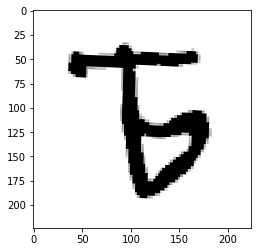

In [0]:
plot_from_ds(tr_ds_tfms,0)

61    ণ্ঠ
Name: component, dtype: object
175    ে
Name: component, dtype: object
179    0
Name: component, dtype: object


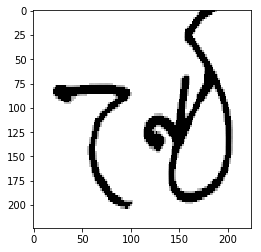

In [0]:
plot_from_ds(va_ds_tfms,0)

In [0]:
tr_ds = tr_ds_tfms
va_ds = va_ds_tfms

In [0]:
len(ds), len(tr_ds), len(va_ds)

(200840, 170714, 30126)

In [0]:
from __future__ import print_function, division, absolute_import
from collections import OrderedDict
import math

import torch.nn as nn
from torch.utils import model_zoo
__all__ = ['SENet', 'se_resnext50_32x4d']
class SEModule(nn.Module):

    def __init__(self, channels, reduction):
        super(SEModule, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc1 = nn.Conv2d(channels, channels // reduction, kernel_size=1,
                             padding=0)
        self.relu = nn.ReLU(inplace=True)
        self.fc2 = nn.Conv2d(channels // reduction, channels, kernel_size=1,
                             padding=0)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        module_input = x
        x = self.avg_pool(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)
        return module_input * x


class Bottleneck(nn.Module):
    """
    Base class for bottlenecks that implements `forward()` method.
    """
    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out = self.se_module(out) + residual
        out = self.relu(out)

        return out


class SEBottleneck(Bottleneck):
    """
    Bottleneck for SENet154.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes * 2, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes * 2)
        self.conv2 = nn.Conv2d(planes * 2, planes * 4, kernel_size=3,
                               stride=stride, padding=1, groups=groups,
                               bias=False)
        self.bn2 = nn.BatchNorm2d(planes * 4)
        self.conv3 = nn.Conv2d(planes * 4, planes * 4, kernel_size=1,
                               bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNetBottleneck(Bottleneck):
    """
    ResNet bottleneck with a Squeeze-and-Excitation module. It follows Caffe
    implementation and uses `stride=stride` in `conv1` and not in `conv2`
    (the latter is used in the torchvision implementation of ResNet).
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None):
        super(SEResNetBottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, planes, kernel_size=1, bias=False,
                               stride=stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, padding=1,
                               groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SEResNeXtBottleneck(Bottleneck):
    """
    ResNeXt bottleneck type C with a Squeeze-and-Excitation module.
    """
    expansion = 4

    def __init__(self, inplanes, planes, groups, reduction, stride=1,
                 downsample=None, base_width=4):
        super(SEResNeXtBottleneck, self).__init__()
        width = math.floor(planes * (base_width / 64)) * groups
        self.conv1 = nn.Conv2d(inplanes, width, kernel_size=1, bias=False,
                               stride=1)
        self.bn1 = nn.BatchNorm2d(width)
        self.conv2 = nn.Conv2d(width, width, kernel_size=3, stride=stride,
                               padding=1, groups=groups, bias=False)
        self.bn2 = nn.BatchNorm2d(width)
        self.conv3 = nn.Conv2d(width, planes * 4, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes * 4)
        self.relu = nn.ReLU(inplace=True)
        self.se_module = SEModule(planes * 4, reduction=reduction)
        self.downsample = downsample
        self.stride = stride


class SENet(nn.Module):

    def __init__(self, block, layers, groups, reduction, dropout_p=0.2,
                 inplanes=128, input_3x3=True, downsample_kernel_size=3,
                 downsample_padding=1, num_classes=1000):        
        super(SENet, self).__init__()
        self.inplanes = inplanes
        if input_3x3:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, 64, 3, stride=2, padding=1,
                                    bias=False)),
                ('bn1', nn.BatchNorm2d(64)),
                ('relu1', nn.ReLU(inplace=True)),
                ('conv2', nn.Conv2d(64, 64, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn2', nn.BatchNorm2d(64)),
                ('relu2', nn.ReLU(inplace=True)),
                ('conv3', nn.Conv2d(64, inplanes, 3, stride=1, padding=1,
                                    bias=False)),
                ('bn3', nn.BatchNorm2d(inplanes)),
                ('relu3', nn.ReLU(inplace=True)),
            ]
        else:
            layer0_modules = [
                ('conv1', nn.Conv2d(3, inplanes, kernel_size=7, stride=2,
                                    padding=3, bias=False)),
                ('bn1', nn.BatchNorm2d(inplanes)),
                ('relu1', nn.ReLU(inplace=True)),
            ]
        # To preserve compatibility with Caffe weights `ceil_mode=True`
        # is used instead of `padding=1`.
        layer0_modules.append(('pool', nn.MaxPool2d(3, stride=2,
                                                    ceil_mode=True)))
        self.layer0 = nn.Sequential(OrderedDict(layer0_modules))
        self.layer1 = self._make_layer(
            block,
            planes=64,
            blocks=layers[0],
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=1,
            downsample_padding=0
        )
        self.layer2 = self._make_layer(
            block,
            planes=128,
            blocks=layers[1],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer3 = self._make_layer(
            block,
            planes=256,
            blocks=layers[2],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.layer4 = self._make_layer(
            block,
            planes=512,
            blocks=layers[3],
            stride=2,
            groups=groups,
            reduction=reduction,
            downsample_kernel_size=downsample_kernel_size,
            downsample_padding=downsample_padding
        )
        self.avg_pool = nn.AvgPool2d(7, stride=1)
        self.dropout = nn.Dropout(dropout_p) if dropout_p is not None else None
        self.last_linear = nn.Linear(512 * block.expansion, num_classes)
        self.graph_pred = nn.Linear(1024,168)
        self.vowel_pred = nn.Linear(1024,11)
        self.cons_pred = nn.Linear(1024,7)

    def _make_layer(self, block, planes, blocks, groups, reduction, stride=1,
                    downsample_kernel_size=1, downsample_padding=0):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=downsample_kernel_size, stride=stride,
                          padding=downsample_padding, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, groups, reduction, stride,
                            downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, groups, reduction))

        return nn.Sequential(*layers)

    def features(self, x):
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        return x

    def logits(self, x):
        x = self.avg_pool(x)
        if self.dropout is not None:
            x = self.dropout(x)
        x = x.view(x.size(0), -1)
        x = self.last_linear(x)
        return x

    def forward(self, x):
        x = self.features(x)
        x = self.logits(x)
        g = self.graph_pred(x)
        v = self.vowel_pred(x)
        c = self.cons_pred(x)
        return g,v,c
    
    def convert_to_grayscale(self):
        with torch.no_grad():
            conv1 = nn.Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
            conv1.weight.data = torch.sum(model.layer0.conv1.weight.data, dim=1, keepdim=True)
            self.layer0.conv1 = conv1
    
def se_resnext50_32x4d(num_classes=1000, pretrained='imagenet'):
    model = SENet(SEResNeXtBottleneck, [3, 4, 6, 3], groups=32, reduction=16,
                  dropout_p=None, inplanes=64, input_3x3=False,
                  downsample_kernel_size=1, downsample_padding=0,
                  num_classes=num_classes)
    return model

In [0]:
model = se_resnext50_32x4d()
model.avg_pool = nn.AdaptiveAvgPool2d(1)
model.last_linear = nn.Linear(model.last_linear.in_features, 1024)
model.convert_to_grayscale()
model = model.to(device)

In [0]:
model.load_state_dict(torch.load('/kaggle/input/fork-submit/bhgd_seresnext_gen2.pth'))

<All keys matched successfully>

In [0]:
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [0]:
tr_dl = DataLoader(tr_ds, batch_size=64, num_workers=0, pin_memory=True, shuffle=True)
va_dl = DataLoader(va_ds, batch_size=64, num_workers=0, pin_memory=True)

In [0]:
criterion = nn.CrossEntropyLoss(reduction='mean')

In [0]:
def rand_bbox(size, lam):
    W = size[2]
    H = size[3]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cutmix(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    bbx1, bby1, bbx2, bby2 = rand_bbox(data.size(), lam)
    data[:, :, bbx1:bbx2, bby1:bby2] = data[indices, :, bbx1:bbx2, bby1:bby2]
    lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (data.size()[-1] * data.size()[-2]))

    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]
    return data, targets

def mixup(data, targets1, targets2, targets3, alpha):
    indices = torch.randperm(data.size(0))
    shuffled_data = data[indices]
    shuffled_targets1 = targets1[indices]
    shuffled_targets2 = targets2[indices]
    shuffled_targets3 = targets3[indices]

    lam = np.random.beta(alpha, alpha)
    data = data * lam + shuffled_data * (1 - lam)
    targets = [targets1, shuffled_targets1, targets2, shuffled_targets2, targets3, shuffled_targets3, lam]

    return data, targets


def mix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    return lam * criterion(preds1, targets1) + (1 - lam) * criterion(preds1, targets2) + lam * criterion(preds2, targets3) + (1 - lam) * criterion(preds2, targets4) + lam * criterion(preds3, targets5) + (1 - lam) * criterion(preds3, targets6)

def single_mix_criterion(preds1,preds2,preds3, targets):
    targets1, targets2,targets3, targets4,targets5, targets6, lam = targets[0], targets[1], targets[2], targets[3], targets[4], targets[5], targets[6]
    return lam * criterion(preds1, targets1)+ (1 - lam) * criterion(preds1, targets2)


In [0]:
tr_losses = []
va_losses = []

In [0]:
def run_epochs(num_epochs,single=False,mix=False):
    epochs = range(num_epochs)
    best_score = 0.0
    #epochs = notebook.tqdm(range(num_epochs))
    for epoch in epochs:
        model.train()
        count = 0
        batches = tr_dl
        #batches = notebook.tqdm(tr_dl)
        for batch in batches:
            count += 1
            optimizer.zero_grad()
            img, g, v, c = batch
            img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
            img = img / 255.0

            if mix :
                if np.random.rand()<0.5:
                    img, targets = mixup(img, g, v, c, 0.15)
                else :
                    img,targets = cutmix(img, g, v, c, 0.15)
              
                g_pred, v_pred, c_pred = model(img)
            
                if single :
                    loss = single_mix_criterion(g_pred,v_pred,c_pred, targets)
                else :
                    loss = mix_criterion(g_pred,v_pred,c_pred,targets)

            else :
                g_pred, v_pred, c_pred = model(img)
                g_loss = criterion(g_pred,g) 
                v_loss = criterion(v_pred,v) 
                c_loss = criterion(c_pred,c) 
                loss = g_loss+v_loss+c_loss
               
            loss.backward()
            optimizer.step()

        print(loss.item())

        with torch.no_grad():
            model.eval()
            avg_g_loss = 0.0
            avg_v_loss = 0.0
            avg_c_loss = 0.0
            g_true = []
            v_true = []
            c_true = []
            g_preds = []
            v_preds = []
            c_preds = []
            count = 0
            batches = va_dl
            #batches = notebook.tqdm(va_dl)
            for batch in batches:
                count += 1
                img, g, v, c = batch
                img, g, v, c = img.to(device), g.to(device), v.to(device), c.to(device)
                img = img / 255.0
                g_pred, v_pred, c_pred = model(img)
                g_loss = criterion(g_pred, g)
                v_loss = criterion(v_pred, v)
                c_loss = criterion(c_pred, c)
                avg_g_loss += g_loss.item()
                avg_v_loss += v_loss.item()
                avg_c_loss += c_loss.item()
                g_true.extend(g.tolist())
                v_true.extend(v.tolist())
                c_true.extend(c.tolist())
                g_preds.extend(g_pred.argmax(1).tolist())
                v_preds.extend(v_pred.argmax(1).tolist())
                c_preds.extend(c_pred.argmax(1).tolist())
            avg_g_loss /= count
            avg_v_loss /= count
            avg_c_loss /= count
            va_losses.append((avg_g_loss, avg_v_loss, avg_c_loss))
            print(sum(va_losses[-1]), va_losses[-1])
            gscore = recall_score(g_true, g_preds, average='macro')
            vscore = recall_score(v_true, v_preds, average='macro')
            cscore = recall_score(c_true, c_preds, average='macro')
            avg_score = gscore*0.5+vscore*0.25+cscore*0.25
            print(gscore)
            print(vscore)
            print(cscore)
            print(avg_score) 
            print(confusion_matrix(v_true, v_preds))
            print(confusion_matrix(c_true, c_preds))
            plt.figure(figsize = (20, 20))
            sn.heatmap(np.log1p(confusion_matrix(g_true, g_preds)))
            plt.show()

4.420804023742676
0.5523043748173238 (0.2892310758241929, 0.1484866553557653, 0.11458664363736559)
0.9491361826151389
0.9818149647948683
0.9688947891695433
0.9622455297986723
[[6177   27    0    0    9    2    2    1    0    0    0]
 [  33 5437    0    8    0    0    0    0    0    1    0]
 [   7    0 3887    1    0    0    0    0    1    0    0]
 [   2   16    0 2466    0    0    0    0    0    0    1]
 [  35    1    1    0 2766    4    3    1    0    0    0]
 [   5    0    0    0    7  759    9    0    0    0    0]
 [  11    1    0    0    3    6  676    0    0    0    0]
 [  25    3    2    0    0    0    0 4187    5   10    1]
 [   0    0    3    0    0    0    0   12  550    0    0]
 [   0   14    1    0    0    0    0   27    0 2389    2]
 [   0    0    1    6    0    0    0    4    1   13  504]]
[[18811     1    33     0     7    36     0]
 [   23  1058     9     0     0     0     0]
 [   76     0  3443     0     2     4     0]
 [    0     0     4    89     1     0     0]
 [   4

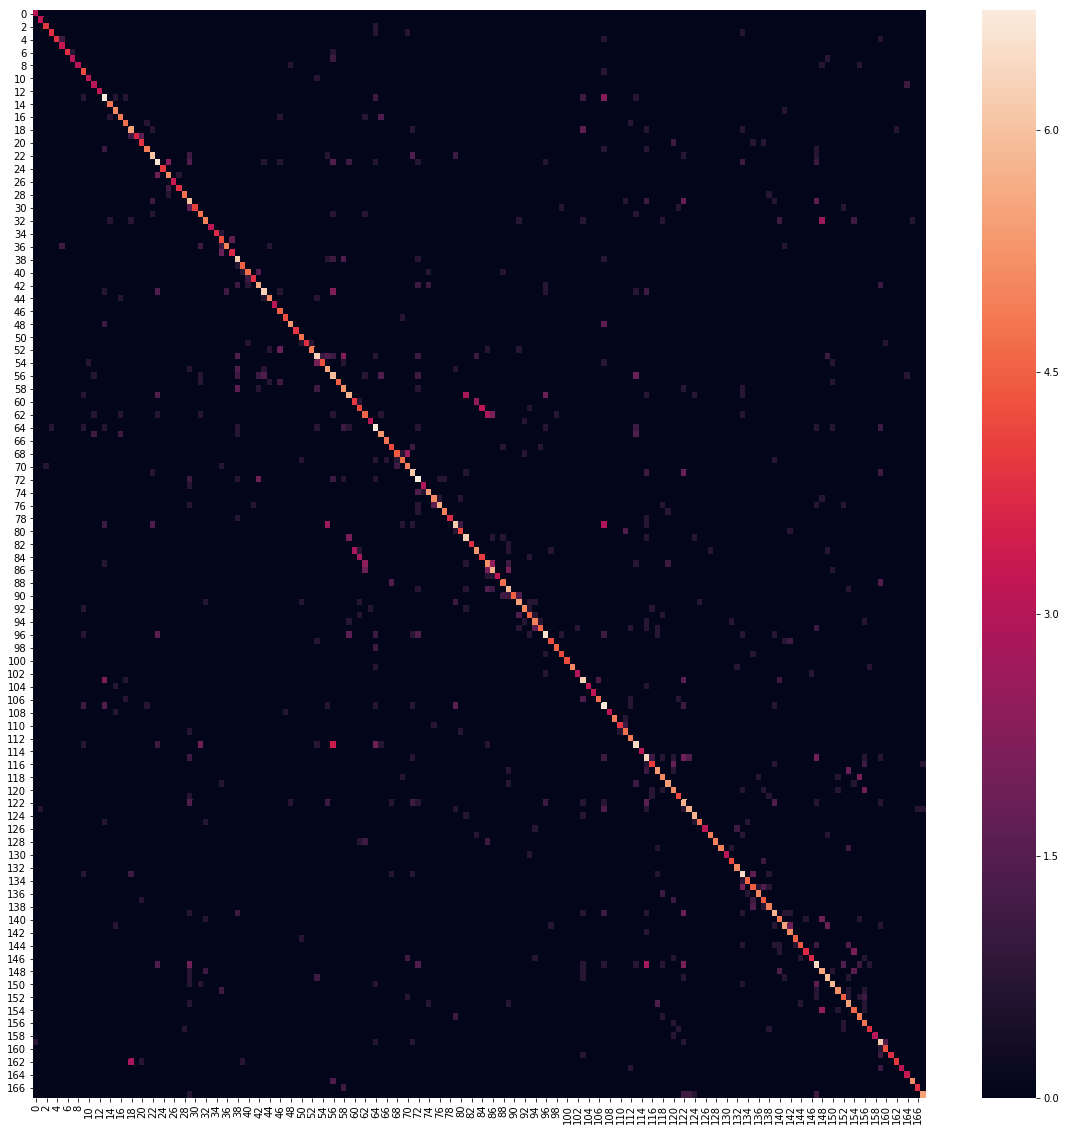

4.647107124328613
0.35474552556619265 (0.20686408428123296, 0.0828631324199228, 0.06501830886503693)
0.9470348662912339
0.9854861334770277
0.9809753099281328
0.9651327939969071
[[6159   30    2    0   19    3    4    1    0    0    0]
 [  34 5435    0    7    0    0    1    0    0    2    0]
 [   8    0 3882    1    0    0    0    4    1    0    0]
 [   1   11    0 2473    0    0    0    0    0    0    0]
 [  21    2    0    0 2777    7    3    1    0    0    0]
 [   5    0    0    0    6  760    9    0    0    0    0]
 [  13    0    0    0    5    6  673    0    0    0    0]
 [   9    2    1    0    0    0    0 4208    4    8    1]
 [   0    0    1    0    0    0    0   10  554    0    0]
 [   0    8    0    0    0    0    0   32    0 2391    2]
 [   0    0    0    0    0    0    0    2    1    7  519]]
[[18760     4    32     0    11    81     0]
 [   16  1068     6     0     0     0     0]
 [   81     0  3438     0     2     4     0]
 [    0     0     1    92     1     0     0]
 [  

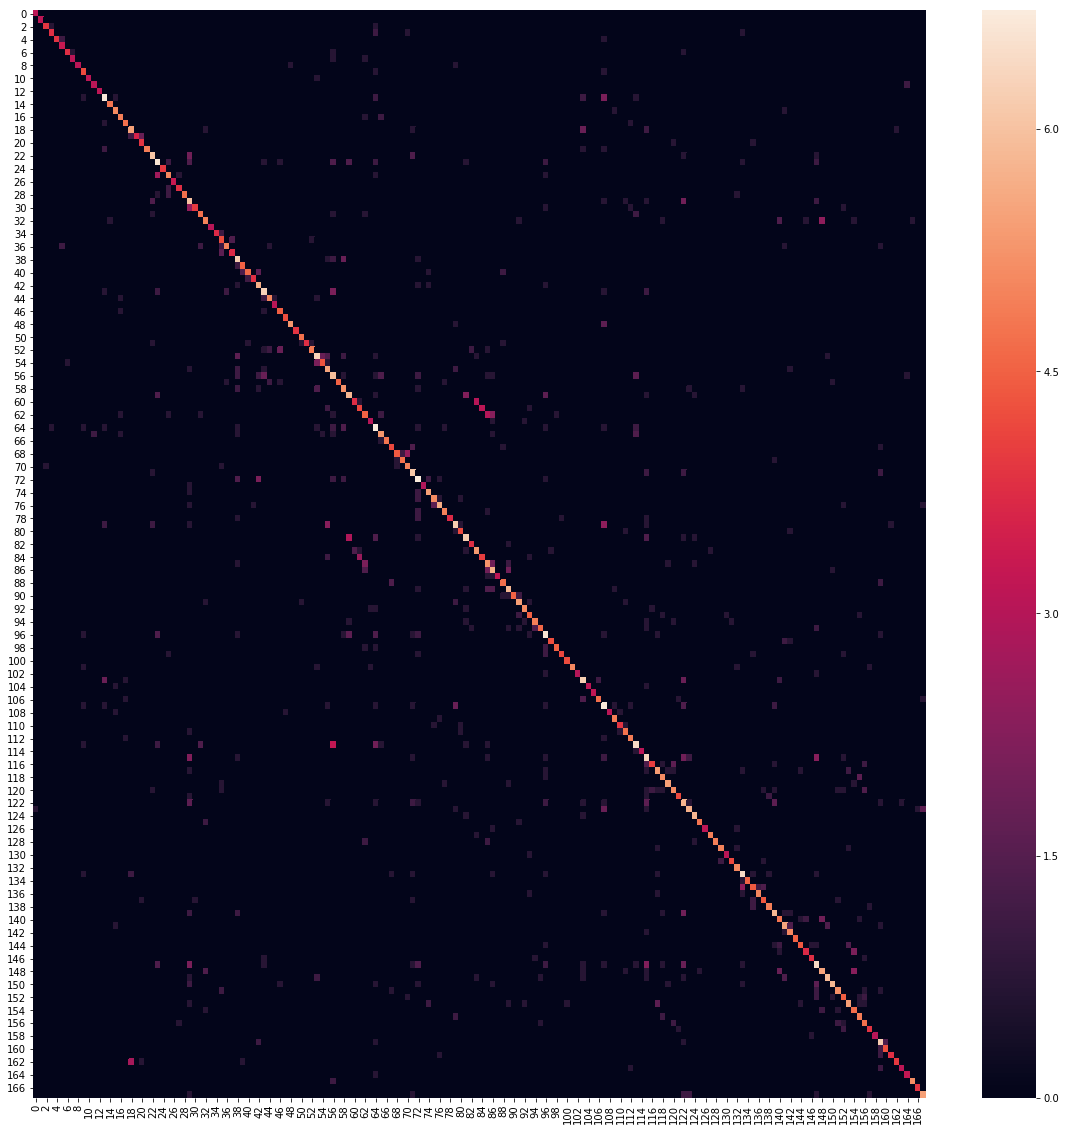

0.01300058513879776
0.4546405897177202 (0.2579415359567938, 0.1066479746908772, 0.09005107907004924)
0.946514410639168
0.9828793337869072
0.9662823692408985
0.9605476310765354
[[6175   22    2    1   16    0    0    2    0    0    0]
 [  47 5415    0   14    1    0    0    0    0    2    0]
 [   9    0 3883    2    0    0    0    1    1    0    0]
 [   2   10    0 2472    0    0    0    0    0    0    1]
 [  31    1    0    0 2776    2    1    0    0    0    0]
 [   5    0    1    0   10  758    6    0    0    0    0]
 [  18    1    0    0   12    5  661    0    0    0    0]
 [  12    1    2    0    2    0    0 4199    4   11    2]
 [   0    0    3    0    0    0    0   11  550    0    1]
 [   0    7    0    0    0    0    1   30    0 2391    4]
 [   0    0    0    0    0    0    0    1    1    7  520]]
[[18800     2    31     0    10    45     0]
 [   24  1057     8     0     1     0     0]
 [   91     0  3430     0     2     2     0]
 [    0     0     3    90     1     0     0]
 [   

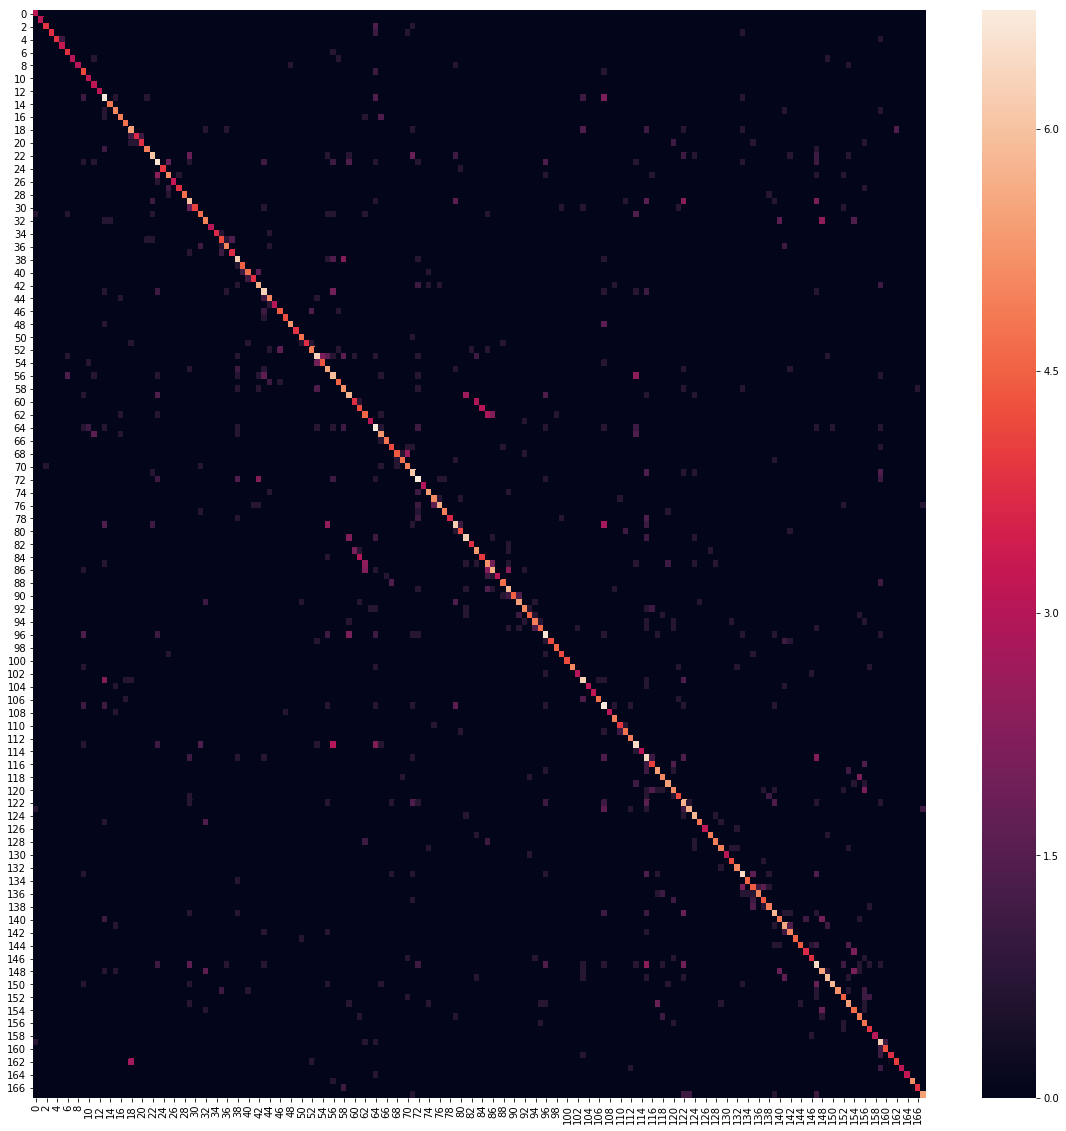

3.7914748191833496
0.35808376432445904 (0.2029548914600836, 0.08728854268820929, 0.06784033017616616)
0.9512432429161957
0.9880975614237003
0.9762291280024608
0.966703293814638
[[6169   23    0    0   18    5    2    1    0    0    0]
 [  26 5441    0    8    1    2    0    0    0    1    0]
 [   7    0 3887    0    0    0    0    0    2    0    0]
 [   1   12    0 2472    0    0    0    0    0    0    0]
 [  27    2    0    0 2777    3    2    0    0    0    0]
 [   3    0    0    0    6  764    7    0    0    0    0]
 [  10    0    0    0    3    4  680    0    0    0    0]
 [  15    1    1    0    0    0    0 4195    8   11    2]
 [   0    0    0    0    0    0    0    5  559    0    1]
 [   0   11    0    0    0    0    0   24    0 2392    6]
 [   0    0    0    0    0    0    0    2    1    5  521]]
[[18804     3    26     0     7    48     0]
 [   13  1073     4     0     0     0     0]
 [   79     1  3438     0     2     5     0]
 [    0     0     2    91     1     0     0]
 [  

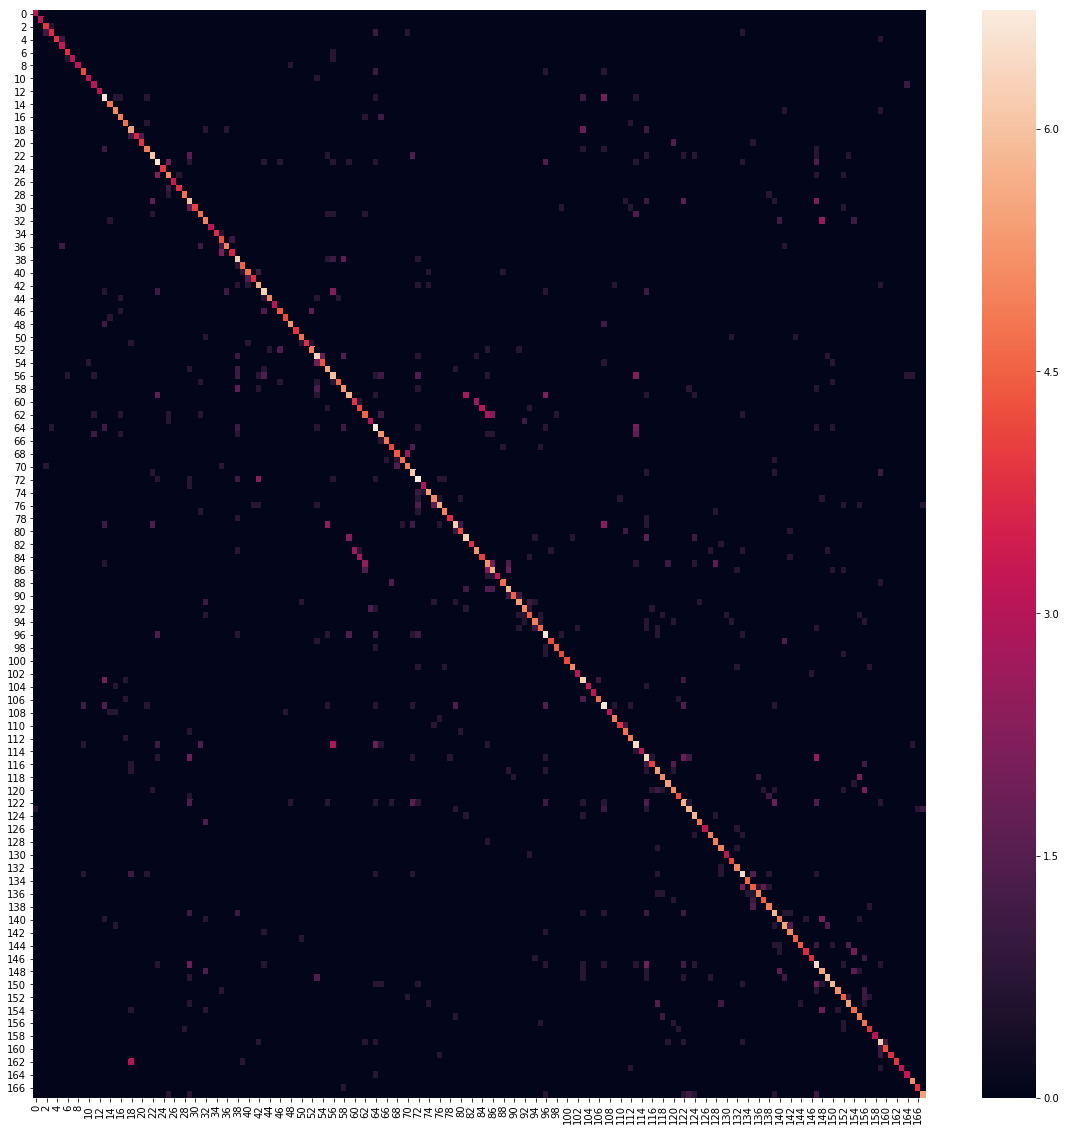

In [0]:
run_epochs(4,mix=True)

In [0]:
torch.save(model.state_dict(),'/kaggle/working/bhgd_seresnext_gen3.pth')